# Create close up plots of segmentation for TA12 (Lactating)

Load libraries.

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import spatialdata_io
import spatialdata as sd

import geopandas as gpd
import spatialdata_plot
from spatialdata import bounding_box_query
import os

Set figure directory.

In [8]:
sc.settings.figdir = "../output/merged_analysis_nuclei/segmentation_plots_publication/"

Read in Xenium data.

In [3]:
sdata = spatialdata_io.xenium("../20240710__115631__100724_Tomo_mouse_gutroll_run2/output-XETG00207__0033724__TA12__20240710__115843", cells_as_shapes =  True)

INFO     reading                                                                                                   
         ../20240710__115631__100724_Tomo_mouse_gutroll_run2/output-XETG00207__0033724__TA12__20240710__115843/cell
         _feature_matrix.h5                                                                                        


/tmp/slurm_8487764/ipykernel_4116099/2587841913.py:1: DeprecationWarning: `cells_as_shapes` is being deprecated as an argument to `xenium.xenium` in SpatialData version 0.1, switch to `cells_as_circles` instead.
  sdata = spatialdata_io.xenium("../20240710__115631__100724_Tomo_mouse_gutroll_run2/output-XETG00207__0033724__TA12__20240710__115843", cells_as_shapes =  True)


Read in clusters from analysis.

In [ ]:
annotations = pd.read_csv("../output/merged_analysis_nuclei/nuclei_meta.csv")
annotations["cell"] = annotations.iloc[:,0]

Prepare transcriptomic layer and add cluster information.

In [7]:
sample = "TA12"
sample_anno = annotations.loc[annotations["sample"] == sample,:]
sample_anno.index = sample_anno["cell"]
cells = list(sample_anno["cell"])
sdata.table.obs_names = sdata.table.obs['cell_id']
adata = sdata.table
adata = adata[cells]
adata.obs["cluster"] = list(sample_anno['epi_res0.5'])
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
del sdata.table
sdata.table = adata
print("sdata prepared")

/tmp/slurm_8487764/ipykernel_4116099/2562427400.py:5: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  sdata.table.obs_names = sdata.table.obs['cell_id']
/tmp/slurm_8487764/ipykernel_4116099/2562427400.py:6: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata = sdata.table
/tmp/slurm_8487764/ipykernel_4116099/2562427400.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cluster"] = list(sample_anno['epi_res0.5'])
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


sdata prepared


/tmp/slurm_8487764/ipykernel_4116099/2562427400.py:12: DeprecationWarning: del sdata.table will be deprecated with SpatialData version 0.1, use del sdata.tables['table'] instead.
  del sdata.table
/tmp/slurm_8487764/ipykernel_4116099/2562427400.py:13: DeprecationWarning: Table setter will be deprecated with SpatialData version 0.1, use tables instead.
  sdata.table = adata


Set colour palette for plots.

In [ ]:
polychrome = ["#5A5156", "#E4E1E3", "#F6222E", "#FE00FA", "#16FF32",\
          "#3283FE", "#FEAF16", "#B00068", "#1CFFCE", "#90AD1C",\
        "#2ED9FF", "#DEA0FD", "#AA0DFE", "#F8A19F", "#325A9B",\
          "#C4451C", "#1C8356", "#85660D", "#B10DA1", "#FBE426",\
          "#1CBE4F", "#FA0087", "#FC1CBF", "#F7E1A0", "#C075A6",\
          "#782AB6", "#AAF400", "#BDCDFF"]

Extract coordinates.

In [8]:
coords = pd.DataFrame(sdata.table.obsm["spatial"])

/tmp/slurm_8487764/ipykernel_4116099/751507538.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  coords = pd.DataFrame(sdata.table.obsm["spatial"])


Plot to select ROI.

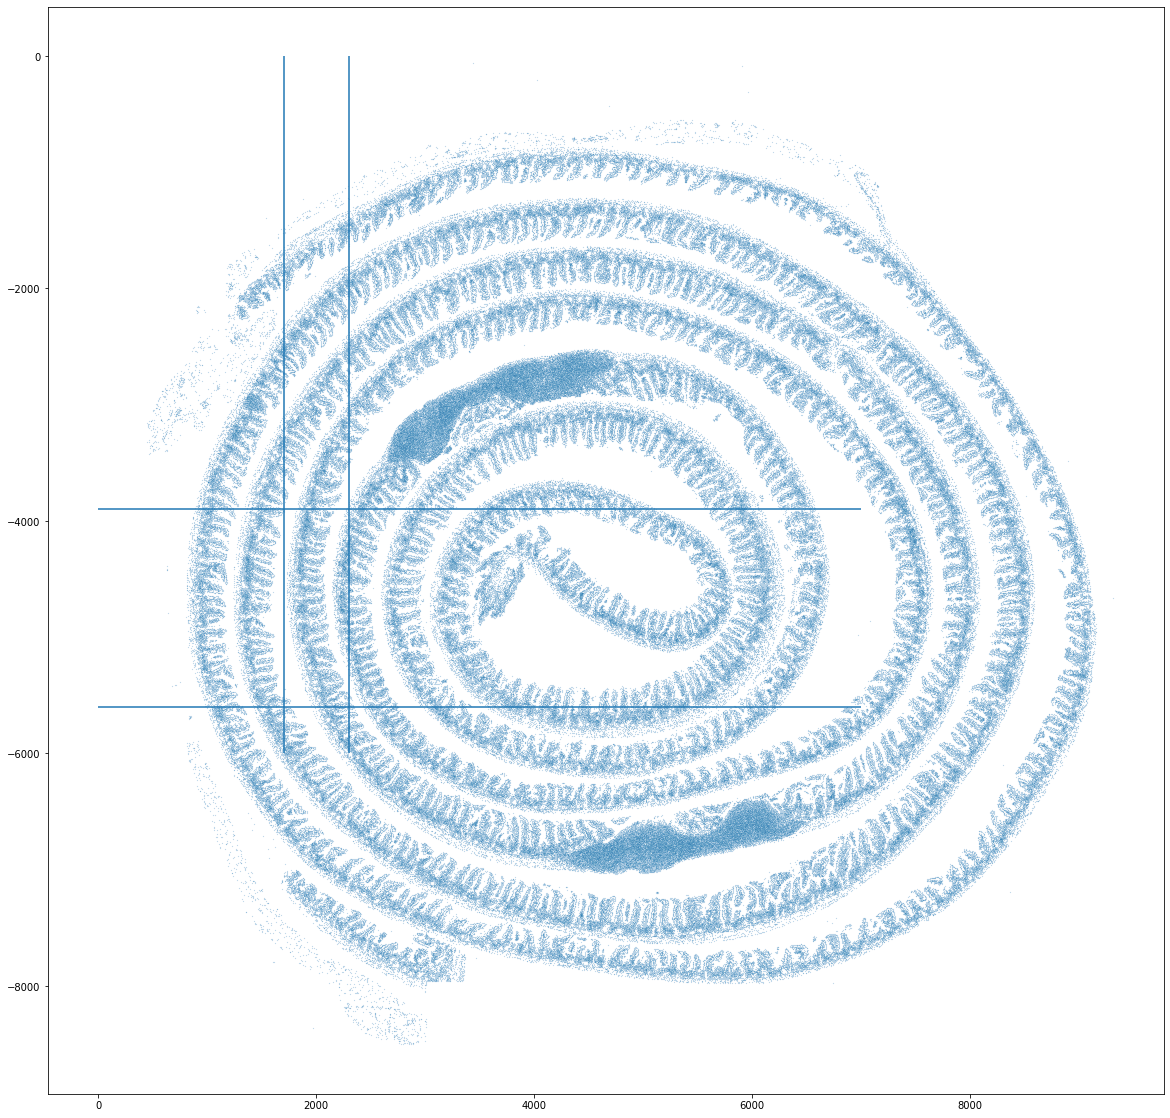

In [19]:
plt.figure(figsize=(20,20))
plt.scatter(coords.loc[:,0],-(coords.loc[:,1]), s = 0.01)
plt.vlines(x = 1700, ymin = -6000, ymax = 0)
plt.vlines(x = 2300, ymin = -6000, ymax = 0)
plt.hlines(y = -3900, xmin = 0, xmax = 7000)
plt.hlines(y = -5600, xmin = 0, xmax = 7000)

Get rough conversion of ROI to pixels.

In [10]:
f =  1/0.2125
print(1700*f)
print(2300*f)
print(3900*f)
print(5600*f)

8000.0
10823.529411764706
18352.941176470587
26352.941176470587


Set metadata (clusters) to link to cell boundaries.

In [22]:
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

/opt/conda/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:474: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


Crop data to ROI.

In [27]:
cropped_sdata = sdata.query.bounding_box(
axes=["x", "y"],
min_coordinate=[8000, 18400],
max_coordinate=[10900, 26400],
target_coordinate_system="global",
)

Prepare data for plotting.

In [ ]:
print("sdata cropped")
cropped_sdata.table.obs["cluster"] = pd.Categorical(cropped_sdata.table.obs["cluster"])
groups = list(cropped_sdata.table.obs["cluster"].cat.categories)
groups = [str(i) for i in groups]
cropped_sdata.table.obs["cluster_str"] = cropped_sdata.table.obs["cluster"].astype(str)
cropped_sdata.table.obs["cluster_str"] = pd.Categorical(cropped_sdata.table.obs["cluster_str"], categories = groups)

Filter cropped data cell boundaries to those whose centroids are included in the cropped data.

In [30]:
cropped_sdata["cell_boundaries"] = cropped_sdata["cell_boundaries"].loc[cropped_sdata.table.obs_names,:]

/tmp/slurm_8487764/ipykernel_4116099/1890243967.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cropped_sdata["cell_boundaries"] = cropped_sdata["cell_boundaries"].loc[cropped_sdata.table.obs_names,:]
/opt/conda/lib/python3.10/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Plot epithelial clusters and segmentations.

INFO     Using matplotlib                                                                                          


/tmp/slurm_8487764/ipykernel_4116099/2028355128.py:1: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `element` instead.
  cropped_sdata.pl.render_shapes(elements="cell_boundaries", outline_width=0.5, outline = True, color = "cluster_str",palette = polychrome[:19], groups = groups).pl.show(title=f"", coordinate_systems="global", figsize=(20, 20), save = sample + "_cluster_image.png")
/opt/conda/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:722: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


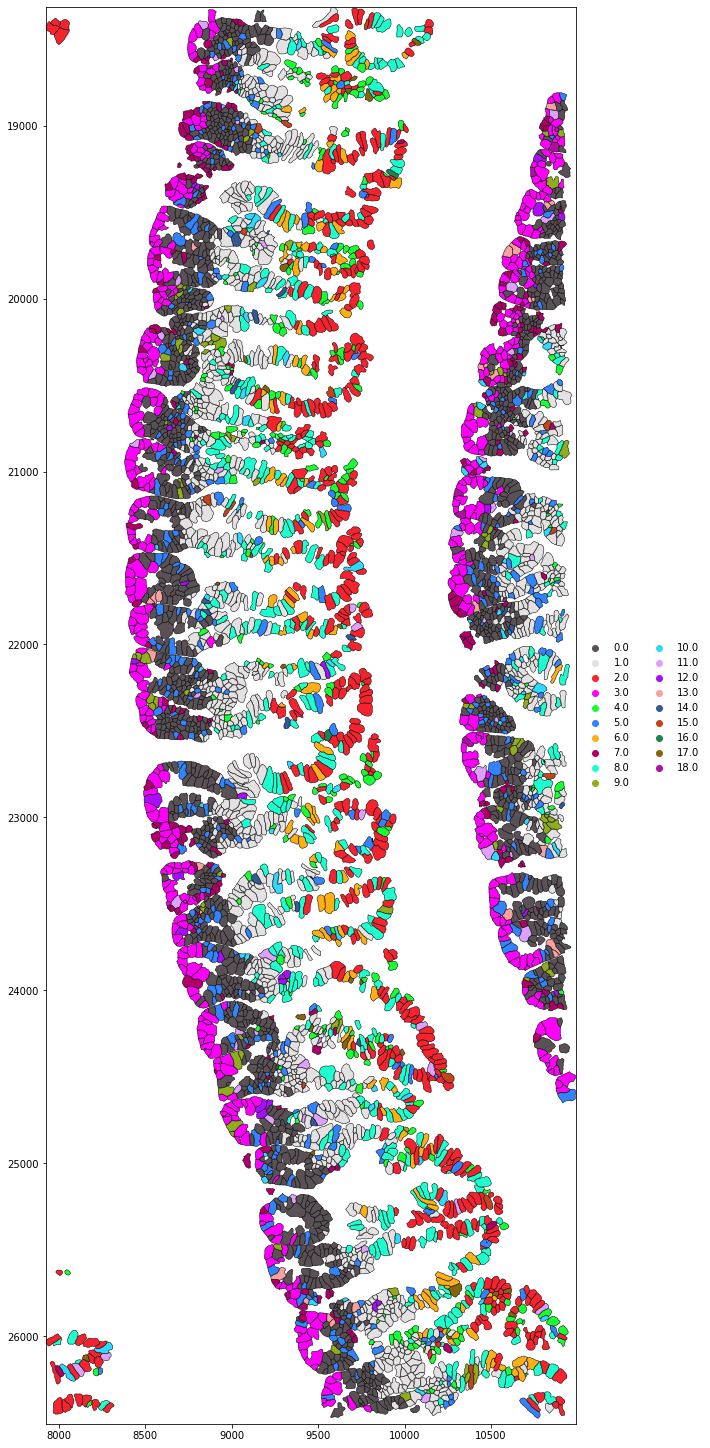

In [31]:
cropped_sdata.pl.render_shapes(elements="cell_boundaries", outline_width=0.5, outline = True, color = "cluster_str",palette = polychrome[:19], groups = groups).pl.show(title=f"", coordinate_systems="global", figsize=(20, 20), save = sample + "_cluster_image.png")

Plot over image.

/tmp/slurm_8487764/ipykernel_4116099/4146688254.py:1: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `element` instead.
  cropped_sdata.pl.render_images("morphology_focus").pl.render_shapes(elements="cell_boundaries", outline_width=0.5, fill_alpha=0.5,outline = True, color = "cluster_str",palette = polychrome[:19], groups = groups).pl.show(title=f"", coordinate_systems="global", figsize=(20, 20), save = sample + "_cluster_image_alpha0.5_over_morphology.png")
/opt/conda/lib/python3.10/site-packages/tifffile/tifffile.py:9422: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8823221837754711].


INFO     Using matplotlib                                                                                          


/opt/conda/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:722: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


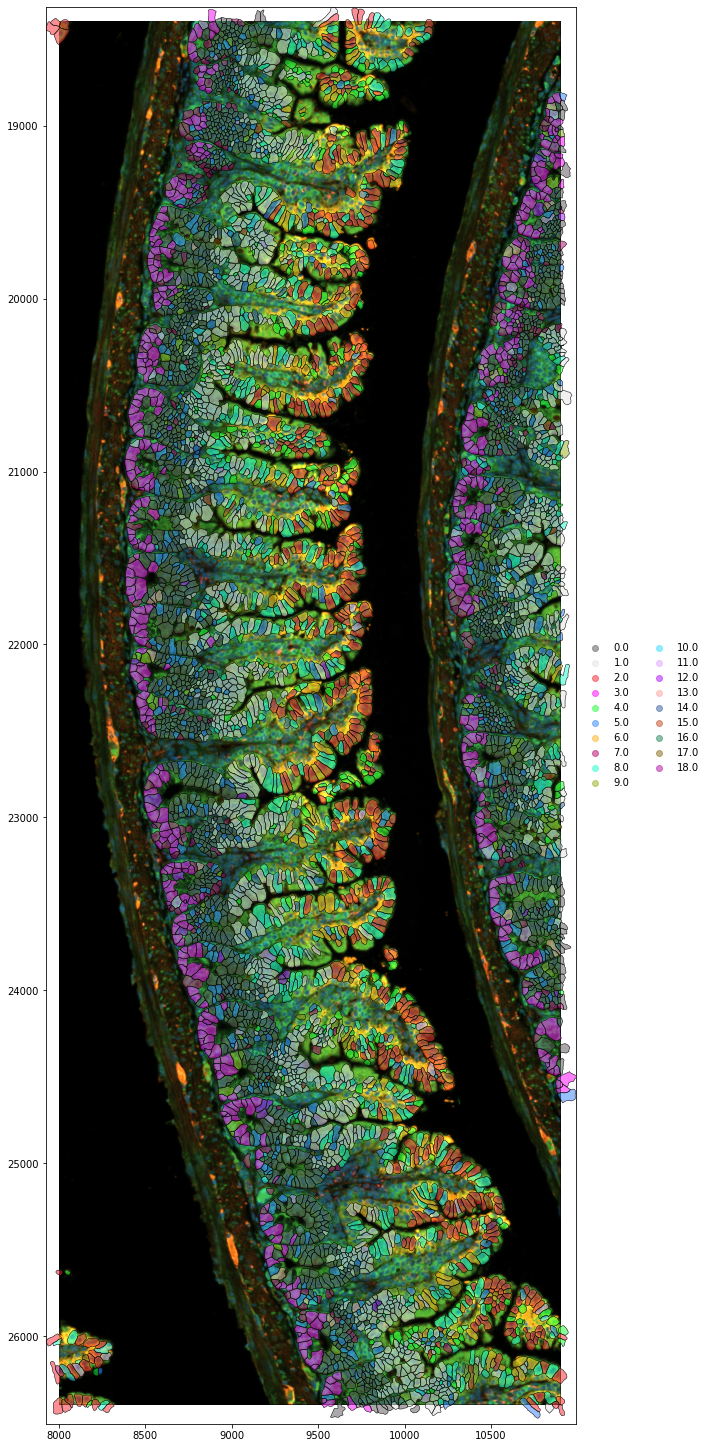

In [32]:
cropped_sdata.pl.render_images("morphology_focus").pl.render_shapes(elements="cell_boundaries", outline_width=0.5, fill_alpha=0.5,outline = True, color = "cluster_str",palette = polychrome[:19], groups = groups).pl.show(title=f"", coordinate_systems="global", figsize=(20, 20), save = sample + "_cluster_image_alpha0.5_over_morphology.png")